### Import packages

In [1]:
import folium
import functools
import geopandas as gpd
import io
import logging
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from opentnsim import core
from opentnsim import lock
from opentnsim import model
from opentnsim import output
from opentnsim import vessel as _vessel
from opentnsim import vessel_traffic_service
import os
import pandas as pd
import pickle
import pyproj
import requests
from shapely.geometry import Point,LineString,Polygon
from shapely.geometry.collection import GeometryCollection
from shapely.ops import transform, linemerge, split, snap
import simpy
import yaml

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

# Basic lock simulation
Remember the exercise on the capacity of a lock that was given by Arne van der Hout? Instead of calculating the lock capacity by hand, we can actually simulate locks using the software of OpenTNSim. How does this work?

First, we create an environment

In [2]:
env = simpy.Environment()

#Also we need to add a time
env.simulation_start = pd.Timestamp('2024-01-01')

We need to create a graph and add to the environment

In [3]:
#We need to create a network over which the vessels will sail
FG = nx.DiGraph()
FG.add_node('A',geometry=Point(0,0))
FG.add_node('B',geometry=Point(0,400))
FG.add_node('C',geometry=Point(0,800))
FG.add_edge('A','B',geometry=LineString([Point(0,0),Point(0,400)]),Info={'length':400})
FG.add_edge('B','A',geometry=LineString([Point(0,400),Point(0,0)]),Info={'length':400})
FG.add_edge('B','C',geometry=LineString([Point(0,400),Point(0,800)]),Info={'length':400})
FG.add_edge('C','B',geometry=LineString([Point(0,800),Point(0,400)]),Info={'length':400})
env.FG = FG
env.FG = nx.MultiDiGraph(env.FG)

#In order from ships to know where they are going we need to add an VTS to the environment
env.vessel_traffic_service = vessel_traffic_service.VesselTrafficService()

Now we need to create the lock infrastructure

In [4]:
#We can now add infrastructure to the network
lock_chamber_I = lock.IsLock(env=env,
                             name='Lock I',
                             node_doors1 = 'A',
                             node_doors2 = 'B',
                             lock_length = 120,
                             lock_width = 18,
                             lock_depth = 6,
                             distance_doors1_from_first_waiting_area=140,
                             distance_doors2_from_second_waiting_area=0,
                             detector_nodes=['A','B'],
                             levelling_time=1500)

lock.IsLockLineUpArea(env=env,
                      name='Lock I',
                      start_node = 'A',
                      end_node = 'B',
                      lineup_length = 120,
                      distance_to_lock_doors=20)

lock.IsLockLineUpArea(env=env,
                      name='Lock I',
                      start_node = 'B',
                      end_node = 'A',
                      lineup_length = 0,
                      effective_lineup_length = 120,
                      distance_to_lock_doors=0)

waiting_area_lock_Ia = lock.IsLockWaitingArea(env=env,
                                              name='Lock I',
                                              node='A',
                                              distance_from_node=140);

lock.IsLockWaitingArea(env=env,
                       name='Lock I',
                       node='B',
                       distance_from_node=0);

In [5]:
#We can now add infrastructure to the network
lock_chamber_II = lock.IsLock(env=env,
                              name='Lock II',
                              node_doors1 = 'B',
                              node_doors2 = 'C',
                              lock_length = 120,
                              lock_width = 18,
                              lock_depth = 6,
                              distance_doors1_from_first_waiting_area=0,
                              distance_doors2_from_second_waiting_area=140,
                              detector_nodes=['B','C'],
                              levelling_time=1500,
                              node_open='B')

lock.IsLockLineUpArea(env=env,
                      name='Lock II',
                      start_node = 'B',
                      end_node = 'C',
                      lineup_length = 0,
                      effective_lineup_length = 120,
                      distance_to_lock_doors=0)

lock.IsLockLineUpArea(env=env,
                      name='Lock II',
                      start_node = 'C',
                      end_node = 'B',
                      lineup_length = 120,
                      distance_to_lock_doors=20)

lock.IsLockWaitingArea(env=env,
                       name='Lock II',
                       node='B',
                       distance_from_node=0)

waiting_area_lockIIb = lock.IsLockWaitingArea(env=env,
                                              name='Lock II',
                                              node='C',
                                              distance_from_node=140);

Now we need to add a vessel

In [6]:
#We create a type element that schematisizes a vessel
Vessel = type('Vessel',(core.SimpyObject, #It should be a simpy element
                        core.Identifiable, #The vessel should be identifiable
                        lock.HasLock, #The vessel should interact with a lock chamber
                        lock.HasWaitingArea, #The vessel should interact with a waiting area
                        lock.HasLineUpArea, #The vessel should interact with a line-up area
                        _vessel.VesselProperties, #The vessel should have properties
                        _vessel.ExtraMetadata, #The vessel can have extra metadata
                        output.HasOutput),{}) #The vessel should have output

#Using the element, we need to give the following information to the vessel
vessel = Vessel(env=env,name='Vessel', 
                geometry=Point(0,0),
                origin='A',
                destination='C',
                route=nx.dijkstra_path(FG,'A','C'),
                type='inland vessel',
                L=100,
                B=15,
                T=5,
                H=4,
                v=4,
                arrival_time=pd.Timestamp('2024-01-01'),)

We can now create a process in the environment in which the vessel will move (from node A to node B)

In [7]:
env.process(vessel.move())

<Process(move) object at 0x1dedcb4ea60>

Run the simulation

In [8]:
env.run()

We can now analyse the logbook of the vessel

In [9]:
vessel_df = pd.DataFrame(vessel.log)
vessel_df

,Time,Location,Action,Status
0,1970-01-01 01:00:00.000000,POINT (0 0),Sailing from node A to node B start,"{'origin': 'A', 'destination': 'C', 'route': [..."
1,1970-01-01 01:00:00.000000,POINT (0 0),Sailing to start of line-up area start,"{'origin': 'A', 'destination': 'C', 'route': [..."
2,1970-01-01 01:00:35.000000,POINT (0 140),Sailing to start of line-up area stop,"{'origin': 'A', 'destination': 'C', 'route': [..."
3,1970-01-01 01:00:35.000000,POINT (0 140),Sailing to position in line-up area start,"{'origin': 'A', 'destination': 'C', 'route': [..."
4,1970-01-01 01:00:58.333333,POINT (0 210),Sailing to position in line-up area stop,"{'origin': 'A', 'destination': 'C', 'route': [..."
5,1970-01-01 01:00:58.333333,POINT (0 210),Sailing to end of line-up area start,"{'origin': 'A', 'destination': 'C', 'route': [..."
6,1970-01-01 01:01:53.888889,POINT (0 260),Sailing to end of line-up area stop,"{'origin': 'A', 'destination': 'C', 'route': [..."
7,1970-01-01 01:01:53.888889,POINT (0 260),Sailing to first set of lock doors start,"{'origin': 'A', 'destination': 'C', 'route': [..."
8,1970-01-01 01:02:16.111111,POINT (0 280),Sailing to first set of lock doors stop,"{'origin': 'A', 'destination': 'C', 'route': [..."
9,1970-01-01 01:02:16.111111,POINT (0 280),Sailing to assigned location in lock start,"{'origin': 'A', 'destination': 'C', 'route': [..."


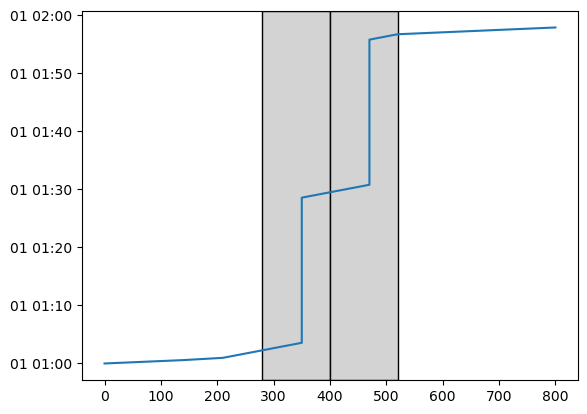

In [10]:
fig,ax = plt.subplots()
ax.plot([point.y for point in vessel_df.Location],vessel_df.Time)
ylim_min,ylim_max = ax.get_ylim()
plt.fill([lock_chamber_I.distance_doors1_from_first_waiting_area+waiting_area_lock_Ia.distance_from_node,
          lock_chamber_I.distance_doors1_from_first_waiting_area+waiting_area_lock_Ia.distance_from_node,
          lock_chamber_I.distance_doors1_from_first_waiting_area+lock_chamber_I.lock_length+waiting_area_lock_Ia.distance_from_node,
          lock_chamber_I.distance_doors1_from_first_waiting_area+lock_chamber_I.lock_length+waiting_area_lock_Ia.distance_from_node,],
          [ylim_min,ylim_max,ylim_max,ylim_min],color='lightgrey',edgecolor='k')

length_lock_complex_I = FG.edges['A','B']['Info']['length']
plt.fill([lock_chamber_II.distance_doors1_from_first_waiting_area+length_lock_complex_I,
          lock_chamber_II.distance_doors1_from_first_waiting_area+length_lock_complex_I,
          lock_chamber_II.distance_doors1_from_first_waiting_area+lock_chamber_II.lock_length+length_lock_complex_I,
          lock_chamber_II.distance_doors1_from_first_waiting_area+lock_chamber_II.lock_length+length_lock_complex_I,],
          [ylim_min,ylim_max,ylim_max,ylim_min],color='lightgrey',edgecolor='k')


ax.set_ylim(ylim_min,ylim_max);

And we can analyse the logbook of the lock

In [11]:
lock_df = pd.DataFrame(lock_chamber_II.log)
lock_df

,Time,Location,Action,Status
0,1970-01-01 01:30:47.222222,B,Lock doors closing start,{'visiting_vessels': [<__main__.Vessel object ...
1,1970-01-01 01:30:47.222222,B,Lock doors closing stop,{'visiting_vessels': [<__main__.Vessel object ...
2,1970-01-01 01:30:47.222222,B,Lock chamber converting start,{'visiting_vessels': [<__main__.Vessel object ...
3,1970-01-01 01:55:47.222222,C,Lock chamber converting stop,{'visiting_vessels': [<__main__.Vessel object ...
4,1970-01-01 01:55:47.222222,C,Lock doors opening start,{'visiting_vessels': [<__main__.Vessel object ...
5,1970-01-01 01:55:47.222222,C,Lock doors opening stop,{'visiting_vessels': [<__main__.Vessel object ...
